# Grad-CAM
<center>
<img src="https://t1.daumcdn.net/cfile/tistory/9963C04C5BC32B9F19" width="600">
</center>

**Limitation of CAM**


A drawback of CAM is that it requires feature maps to directly precede softmax layers, so it is only applicable to a
particular kind of CNN architectures performing global average pooling over convolutional maps immediately prior to
prediction (i.e. conv feature maps -> global average pooling
-> softmax layer)


**Grad-CAM**

Researchers introduce a
new way of combining feature maps using the gradient signal
that does not require any modification in the network architecture.


**Method**

$$
L_{\mbox{Grad-CAM}}^C = \mbox{Relu}(\sum_k \alpha_k^cA^k )
$$

- $\sum_k \alpha_k^cA^k $: linear combination

$$
\alpha_k^c = \frac{1}{Z} \sum_i \sum_j \frac{\partial y^c}{\partial A_{ij}^k}
$$

- $\sum_i \sum_j$: global average pooling
- $y^c$: score for class c
- $A_{ij}^k$: feature map activations

# Import module


In [0]:
# import module
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable

import torch.nn.functional as F
from skimage.transform import resize
import matplotlib.pyplot as plt
%matplotlib inline  
import random

# Hyperparameters



In [0]:
batch_size = 16
learning_rate = 0.0001
num_epoch = 10

# Data load: MNIST


In [0]:
mnist_train = dset.MNIST("./", train=True, 
                         transform=transforms.Compose([
                            transforms.RandomCrop(22),
                            transforms.Resize(226),
                            transforms.ToTensor(),
                         ]), 
                         target_transform=None, 
                         download=True)

mnist_test = dset.MNIST("./", train=False,
                        transform=transforms.Compose([
                            transforms.RandomCrop(22),
                            transforms.Resize(226),
                            transforms.ToTensor(),
                        ]),
                        target_transform=None, 
                        download=True)

train_loader = torch.utils.data.DataLoader(mnist_train,batch_size=batch_size, shuffle=True,num_workers=2,drop_last=True)
test_loader = torch.utils.data.DataLoader(mnist_test,batch_size=batch_size, shuffle=True,num_workers=2,drop_last=True)

# Model: VGG16

<center/>
<img src="https://neurohive.io/wp-content/uploads/2018/11/vgg16.png" width=500>
</center>





In [0]:
import torchvision.models as models
model = models.vgg16(pretrained=True)
model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, 10)

## Train


In [0]:
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
model.cuda()
for i in range(num_epoch):
    model.train()
    for j,[image,label] in enumerate(train_loader):
        x = Variable(image)
        x = torch.cat([x, x, x], dim=1).type(torch.FloatTensor).cuda()
        y_= Variable(label).cuda()
        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_func(output,y_)
        loss.backward()
        optimizer.step()
        
         
    top_1_count = torch.FloatTensor([0])
    total = torch.FloatTensor([0])
    model.eval() 
    for image,label in test_loader:
        x = Variable(image)
        x = torch.cat([x, x, x], dim=1).type(torch.FloatTensor).cuda()
        y_= Variable(label).cuda()

        output = model.forward(x)
        
        values,idx = output.max(dim=1)
        top_1_count += torch.sum(y_==idx).float().cpu().data

        total += label.size(0)

    print("Test Data Accuracy: {}%".format(100*(top_1_count/total).numpy()))
    if (top_1_count/total).numpy() > 0.98:
        break

Test Data Accuracy: [97.78]%


KeyboardInterrupt: ignored

# Grad-CAM module

$$
L_{\mbox{Grad-CAM}}^C = \mbox{Relu}(\sum_k \alpha_k^cA^k )
$$

- $\sum_k \alpha_k^cA^k $: linear combination

$$
\alpha_k^c = \frac{1}{Z} \sum_i \sum_j \frac{\partial y^c}{\partial A_{ij}^k}
$$

- $\sum_i \sum_j$: global average pooling
- $y^c$: score for class c
- $A_{ij}^k$: feature map activations

In [0]:
from collections import OrderedDict, Sequence

import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
from tqdm import tqdm

class _BaseWrapper(object):

    def __init__(self, model):
        super(_BaseWrapper, self).__init__()
        self.device = next(model.parameters()).device
        self.model = model
        self.handlers = []  # a set of hook function handlers

    def _encode_one_hot(self, ids):
        one_hot = torch.zeros_like(self.logits).to(self.device)
        one_hot[0][ids] = 1
        return one_hot

    def forward(self, image):
        """
        Simple classification
        """
        self.model.zero_grad()
        self.logits = self.model(image)
        self.probs = F.softmax(self.logits, dim=1)
        return self.probs.sort(dim=1, descending=True)

    def backward(self, ids):
        """
        Class-specific backpropagation
        Either way works:
        1. self.logits.backward(gradient=one_hot, retain_graph=True)
        2. (self.logits * one_hot).sum().backward(retain_graph=True)
        """

        one_hot = self._encode_one_hot(ids)
        self.logits.backward(gradient=one_hot, retain_graph=True)

    def generate(self):
        raise NotImplementedError

    def remove_hook(self):
        """
        Remove all the forward/backward hook functions
        """
        for handle in self.handlers:
            handle.remove()

class GradCAM(_BaseWrapper):
    """
    "Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization"
    https://arxiv.org/pdf/1610.02391.pdf
    Look at Figure 2 on page 4
    """

    def __init__(self, model, candidate_layers=['features.30']):
        super(GradCAM, self).__init__(model)
        self.fmap_pool = OrderedDict()
        self.grad_pool = OrderedDict()
        self.candidate_layers = candidate_layers  # list

        def forward_hook(key):
            def forward_hook_(module, input, output):
                # Save featuremaps
                self.fmap_pool[key] = output.detach()

            return forward_hook_

        def backward_hook(key):
            def backward_hook_(module, grad_in, grad_out):
                # Save the gradients correspond to the featuremaps
                self.grad_pool[key] = grad_out[0].detach()

            return backward_hook_

        # If any candidates are not specified, the hook is registered to all the layers.
        for name, module in self.model.named_modules():
            if self.candidate_layers is None or name in self.candidate_layers:
                self.handlers.append(module.register_forward_hook(forward_hook(name)))
                self.handlers.append(module.register_backward_hook(backward_hook(name)))

    def _find(self, pool, target_layer):
        if target_layer in pool.keys():
            return pool[target_layer]
        else:
            raise ValueError("Invalid layer name: {}".format(target_layer))

    def _compute_grad_weights(self, grads):
        return F.adaptive_avg_pool2d(grads, 1)

    def forward(self, image):
        self.image_shape = image.shape[2:]
        return super(GradCAM, self).forward(image)

    def generate(self, target_layer):
        fmaps = self._find(self.fmap_pool, target_layer)
        grads = self._find(self.grad_pool, target_layer)
        weights = self._compute_grad_weights(grads)

        gcam = torch.mul(fmaps, weights).sum(dim=1, keepdim=True)
        gcam = F.relu(gcam)

        gcam = F.interpolate(
            gcam, self.image_shape, mode="bilinear", align_corners=False
        )

        B, C, H, W = gcam.shape
        gcam = gcam.view(B, -1)
        gcam -= gcam.min(dim=1, keepdim=True)[0]
        gcam /= gcam.max(dim=1, keepdim=True)[0]
        gcam = gcam.view(B, C, H, W)

        return gcam


# Prepare Sample data

In [0]:
for images, labels in train_loader:
    image, label = images[0], labels[0]
    break

In [0]:
image = torch.cat([image, image, image], dim=0)
image = torch.unsqueeze(image, dim=0)

torch.Size([1, 3, 226, 226])

In [0]:
gcam = GradCAM(model=model)
probs, ids = gcam.forward(image.cuda())
target_class = 7
ids_ = torch.LongTensor([[target_class]]).cuda()
gcam.backward(ids=ids_)

In [0]:
img = image.cpu().numpy()[0][0]
img.shape

(226, 226)

# Visualization

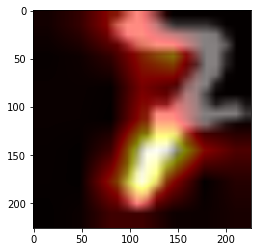

In [0]:
regions = gcam.generate(target_layer='features.30')
regions = regions.detach().cpu().numpy()
regions = np.squeeze(regions)

plt.imshow(img, cmap=plt.cm.gray)
plt.imshow(regions, cmap="hot", alpha=0.5)
plt.show()